Selecciona una imagen para procesar en CPU:


Saving original.jpg to original.jpg
Imagen cargada: original.jpg

 TIEMPOS CPU
Escala de grises: 0.0159s
Sobel CPU:        7.9486s

 Resultado CPU:


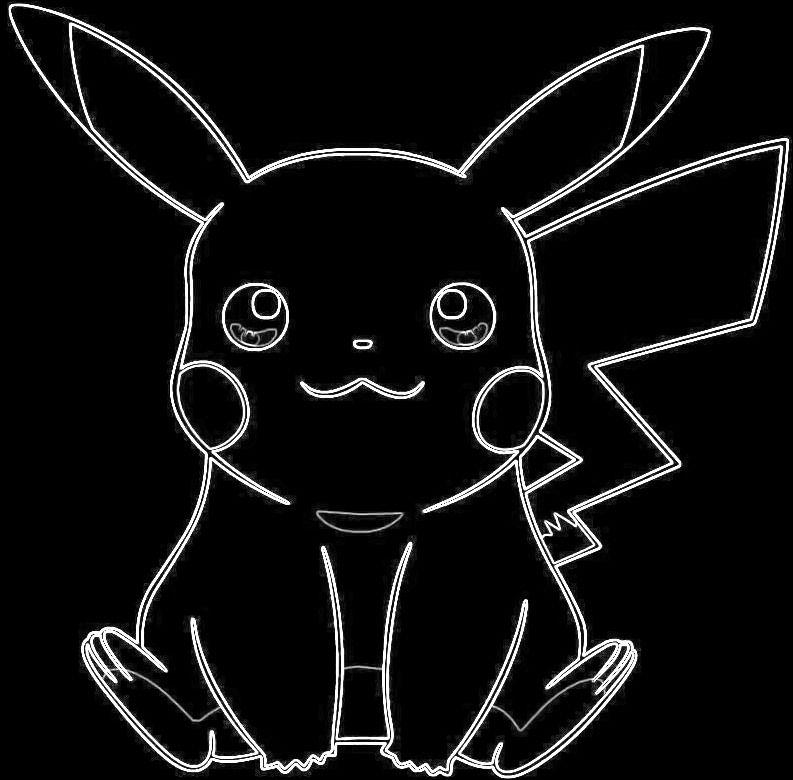


 Archivo generado: resultado_cpu.png


In [1]:
import cv2
import numpy as np
import math
import time
from google.colab import files
from google.colab.patches import cv2_imshow

#sobel cpu

def to_grayscale_cpu(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def sobel_cpu(gray):
    rows, cols = gray.shape
    output = np.zeros_like(gray)

    Kx = np.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]], dtype=np.int32)

    Ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]], dtype=np.int32)

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):

            region = gray[i-1:i+2, j-1:j+2]

            Gx = np.sum(Kx * region)
            Gy = np.sum(Ky * region)

            mag = int(math.sqrt(Gx*Gx + Gy*Gy))
            output[i, j] = min(255, mag)

    return output

print("Selecciona una imagen para procesar en CPU:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"Imagen cargada: {filename}")

img = cv2.imread(filename)

t0 = time.time()
gray = to_grayscale_cpu(img)
t_gray = time.time() - t0

t0 = time.time()
sobel_out = sobel_cpu(gray)
t_sobel = time.time() - t0

print("\n TIEMPOS CPU")
print(f"Escala de grises: {t_gray:.4f}s")
print(f"Sobel CPU:        {t_sobel:.4f}s")

cv2.imwrite("resultado_cpu.png", sobel_out)

print("\n Resultado CPU:")
cv2_imshow(sobel_out)

print("\n Archivo generado: resultado_cpu.png")


Selecciona una imagen para procesar en GPU:


Saving original.jpg to original.jpg
Imagen cargada: original.jpg

 TIEMPO GPU
Sobel GPU: 1.1433s

 Resultado GPU:


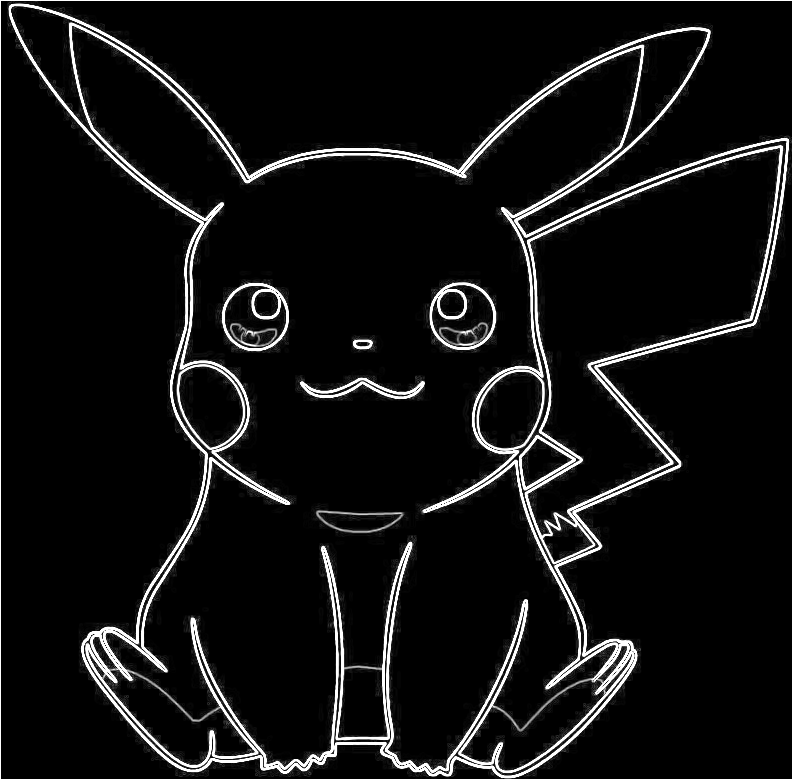


 Archivo generado: resultado_gpu.png


In [1]:
!pip install cupy-cuda12x

import cv2
import cupy as cp
import numpy as np
import time
from google.colab import files
from google.colab.patches import cv2_imshow


# convolucion

def convolve2d_gpu(img, kernel):
    kh, kw = kernel.shape
    pad_h = kh // 2
    pad_w = kw // 2

    # Padding en GPU
    padded = cp.pad(img, ((pad_h, pad_h), (pad_w, pad_w)))

    # salida
    out = cp.zeros_like(img)

    # Realizar convolución manual en GPU
    for i in range(kh):
        for j in range(kw):
            out += kernel[i, j] * padded[i:i+img.shape[0], j:j+img.shape[1]]

    return out


# sobel gpu

def sobel_gpu(gray_gpu):
    Kx = cp.array([[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]], dtype=cp.float32)

    Ky = cp.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]], dtype=cp.float32)

    Gx = convolve2d_gpu(gray_gpu, Kx)
    Gy = convolve2d_gpu(gray_gpu, Ky)

    mag = cp.sqrt(Gx*Gx + Gy*Gy)
    mag = cp.clip(mag, 0, 255)

    return mag.astype(cp.uint8)


print("Selecciona una imagen para procesar en GPU:")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"Imagen cargada: {filename}")

img = cv2.imread(filename)
gray_cpu = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_gpu = cp.array(gray_cpu, dtype=cp.float32)

t0 = time.time()
sobel_out_gpu = sobel_gpu(gray_gpu)
cp.cuda.Stream.null.synchronize()
t_gpu = time.time() - t0

sobel_out_np = cp.asnumpy(sobel_out_gpu)

print("\n TIEMPO GPU")
print(f"Sobel GPU: {t_gpu:.4f}s")

cv2.imwrite("resultado_gpu.png", sobel_out_np)

print("\n Resultado GPU:")
cv2_imshow(sobel_out_np)

print("\n Archivo generado: resultado_gpu.png")
